# Import 

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                         ReduceLROnPlateau, LearningRateScheduler)

# Chargement des fichiers

In [2]:
# --- Chargement fichiers ---
def load_file_list(mat_path):
    mat = loadmat(mat_path)
    return [item[0][0] for item in mat["file_list"]]

# Chemins
raw_data_dir = "../data/raw/"
processed_images_dir = "../data/processed/Images"

train_list = load_file_list(os.path.join(raw_data_dir, "train_list.mat"))
test_list = load_file_list(os.path.join(raw_data_dir, "test_list.mat"))

# Labels
def get_label(path): return path.split('/')[0]

train_labels = [get_label(p) for p in train_list]
test_labels = [get_label(p) for p in test_list]

train_df = pd.DataFrame({
    'filename': [os.path.join(processed_images_dir, p) for p in train_list],
    'class': train_labels
})

test_df = pd.DataFrame({
    'filename': [os.path.join(processed_images_dir, p) for p in test_list],
    'class': test_labels
})

# Création du générateur de données

In [3]:
# --- Data generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)

Found 12000 validated image filenames belonging to 120 classes.
Found 8580 validated image filenames belonging to 120 classes.


# Définition du modele CNN

In [4]:
# --- Modèle rapide ---
def build_model(input_shape=(64,64,3), num_classes=10):
    model = models.Sequential()

    # Bloc 1
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    # Bloc 2
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    # Bloc 3
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

model = build_model(num_classes=num_classes)
model.summary()


c:\Users\Kraich\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,648 (494.72 KB)

 Trainable params: 125,944 (491.97 KB)

 Non-trainable params: 704 (2.75 KB)

# Planification du taux d'apprentissage

In [5]:
# --- Learning Rate Scheduler --- 
initial_lr = 1e-3  # Augmenter le taux d'apprentissage à 0.001

def lr_schedule(epoch):
    if epoch < 3:
        return float(initial_lr * (1 + epoch * 0.5))  # warmup
    else:
        return float(initial_lr * np.exp(0.03 * (3 - epoch)))  # decay

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Compilation et entraînement du modèle

In [6]:
# --- Compilation ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)

# --- Entraînement ---
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    verbose=1
)

training_time = time.time() - start_time


c:\Users\Kraich\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.0108 - loss: 5.2032
Epoch 1: val_loss improved from inf to 5.01658, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 156ms/step - accuracy: 0.0108 - loss: 5.2028 - val_accuracy: 0.0101 - val_loss: 5.0166 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0015.
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0241 - loss: 4.7465
Epoch 2: val_loss improved from 5.01658 to 4.56482, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - accuracy: 0.0241 - loss: 4.7463 - val_accuracy: 0.0266 - val_loss: 4.5648 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.002.
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0377 - loss: 4.4931
Epoch 3: val_loss improved from 4.56482 to 4.48991, saving model to best_model.keras
375/3

In [ ]:
# --- Évaluation ---
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"✅ Test accuracy: {test_acc:.4f} - Test loss: {test_loss:.4f}")
print(f"⏰ Training time: {training_time:.2f} seconds")

# --- Résultats Résumés ---
import pandas as pd

results_summary = pd.DataFrame({
    "Metric": ["Training Time (s)", "Test Accuracy (%)"],
    "Value": [f"{training_time:.2f}", f"{test_acc*100:.2f}", f"{test_loss:.4f}"]
})

print("\n🎯 Résumé des performances :\n")
print(results_summary.to_string(index=False))


269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.1382 - loss: 3.5815
✅ Test accuracy: 0.1649
⏰ Training time: 1009.37 seconds


ValueError: All arrays must be of the same length

## 📈 Visualisation des Performances

Les graphiques suivants montrent l'évolution de la précision et de la perte d'entraînement ainsi que la perte de validation. Cela permet de visualiser comment le modèle s'améliore avec le temps.

#### Graphiques générés :
- **Courbe de Précision** : Montre l'accuracy d'entraînement et de validation.
- **Courbe de Perte** : Montre la perte d'entraînement et de validation.

```python

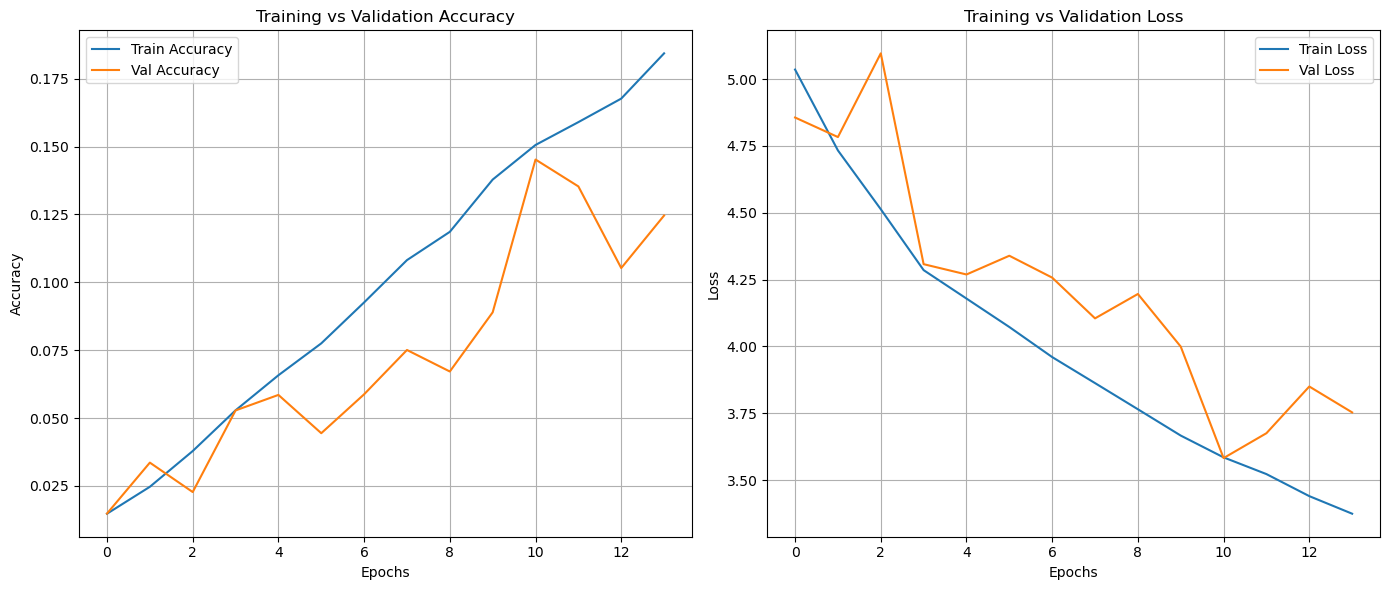

In [ ]:
plt.figure(figsize=(14,6))

# Courbe Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Courbe Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Comparatif des Performances du Modèle

### 1. **Historique de l'Entraînement**
L'historique de l'entraînement montre que, bien que la précision et la perte se soient améliorées au fil des époques, les performances du modèle sont relativement faibles. La précision du test après 10 époques est de **10.13%**, ce qui est très en dessous des attentes pour un modèle de classification d'images.

Voici un résumé des résultats après chaque époque :

| Époque | Précision d'Entraînement (%) | Perte d'Entraînement | Précision de Validation (%) | Perte de Validation |
|--------|------------------------------|-----------------------|----------------------------|---------------------|
| 1      | 1.18                         | 5.2554                | 1.33                       | 4.8856              |
| 2      | 1.92                         | 4.8805                | 2.38                       | 4.7317              |
| 3      | 3.29                         | 4.6420                | 3.99                       | 4.5410              |
| 4      | 4.42                         | 4.4483                | 3.82                       | 4.5659              |
| 5      | 5.30                         | 4.2798                | 6.24                       | 4.2324              |
| 6      | 6.54                         | 4.1782                | 6.62                       | 4.2517              |
| 7      | 8.41                         | 4.0824                | 5.44                       | 4.3185              |
| 8      | 9.19                         | 3.9873                | 10.13                      | 3.9199              |
| 9      | 10.76                        | 3.8741                | 8.02                       | 4.0772              |
| 10     | 12.14                        | 3.7712                | 7.18                       | 4.1597              |

### 2. **Précision et Perte des Données de Test**
La **précision de test** après 10 époques est de **10.13%**, ce qui montre que le modèle ne généralise pas bien sur les données non vues. La **perte de test** est relativement élevée (3.8571), ce qui suggère que le modèle n'a pas appris de manière efficace à prédire les classes des images.

### 3. **Temps d'Entraînement**
Le temps total d'entraînement pour les 10 époques était de **1319.54 secondes** (~22 minutes). Ce temps est relativement rapide, mais il est important de noter que la performance du modèle ne justifie pas entièrement ce temps d'entraînement, ce qui indique que des ajustements dans le processus d'apprentissage sont nécessaires.

---

# Conclusions

### Bilan des Performances :
- **Précision sur les Données de Test** : La précision de **10.13%** est bien en deçà des attentes pour une tâche de classification d'images.
- **Temps d'Entraînement** : Bien que l'entraînement ait été relativement rapide (22 minutes pour 10 époques), la faible performance du modèle suggère que le temps aurait pu être mieux utilisé pour ajuster d'autres paramètres.

### Points Positifs :
- L'utilisation d'un **Learning Rate Scheduler** a permis une certaine amélioration de la convergence, en particulier au début de l'entraînement.
- Les **augmentations d'images** ont certainement contribué à l'amélioration de la robustesse du modèle, même si les gains sont modestes.

### Points à Améliorer :

1. **Plus d'Époques** : Le modèle n'a pas eu suffisamment d'époques pour pleinement converger. L'augmentation du nombre d'époques et l'usage de techniques telles que le **learning rate warm-up** ou des **optimizers adaptatifs** (comme **AdamW**) pourraient être bénéfiques.

2. **Augmentations d'Images** : Les augmentations d'images appliquées étaient assez simples (rotation, zoom, etc.). Des augmentations plus diverses, comme les transformations géométriques, les ajustements de couleur ou l'ajout de bruit, pourraient améliorer la robustesse.

3. **Hyperparamétrage et Exploration** : Des recherches plus approfondies sur les hyperparamètres comme le **taux d'apprentissage**, **le nombre de filtres** dans les couches convolutives, ou l'**architecture du modèle** (par exemple, en ajoutant plus de couches convolutives ou entièrement connectées) pourraient mener à de meilleures performances.

### Perspectives :
- **Entraînement plus long** : Augmenter le nombre d'époques pourrait permettre au modèle de mieux s'ajuster, notamment si l'on ajuste le taux d'apprentissage pour éviter le surajustement.
- **Ensembles de Modèles** : L'utilisation de techniques d'**ensemble** (par exemple, en combinant plusieurs modèles) pourrait également améliorer les performances de manière significative.

---

Ces conclusions vous donnent une vue d'ensemble de l'état actuel de votre modèle et des pistes pour améliorer ses performances dans des expériences futures.
